Running simulation with 1 layers...
Number of layers 1
Step 0 out of 10
Step 1 out of 10
Step 2 out of 10
Step 3 out of 10
Step 4 out of 10
Step 5 out of 10
Step 6 out of 10
Step 7 out of 10
Step 8 out of 10
Step 9 out of 10
Running simulation with 2 layers...
Number of layers 2
Step 0 out of 10
Step 1 out of 10
Step 2 out of 10
Step 3 out of 10
Step 4 out of 10
Step 5 out of 10
Step 6 out of 10
Step 7 out of 10
Step 8 out of 10
Step 9 out of 10
Running simulation with 3 layers...
Number of layers 3
Step 0 out of 10
Step 1 out of 10
Step 2 out of 10
Step 3 out of 10
Step 4 out of 10
Step 5 out of 10
Step 6 out of 10
Step 7 out of 10
Step 8 out of 10
Step 9 out of 10
Running simulation with 4 layers...
Number of layers 4
Step 0 out of 10
Step 1 out of 10
Step 2 out of 10
Step 3 out of 10
Step 4 out of 10
Step 5 out of 10
Step 6 out of 10
Step 7 out of 10
Step 8 out of 10
Step 9 out of 10
Running simulation with 5 layers...
Number of layers 5
Step 0 out of 10
Step 1 out of 10
Step 2 out 

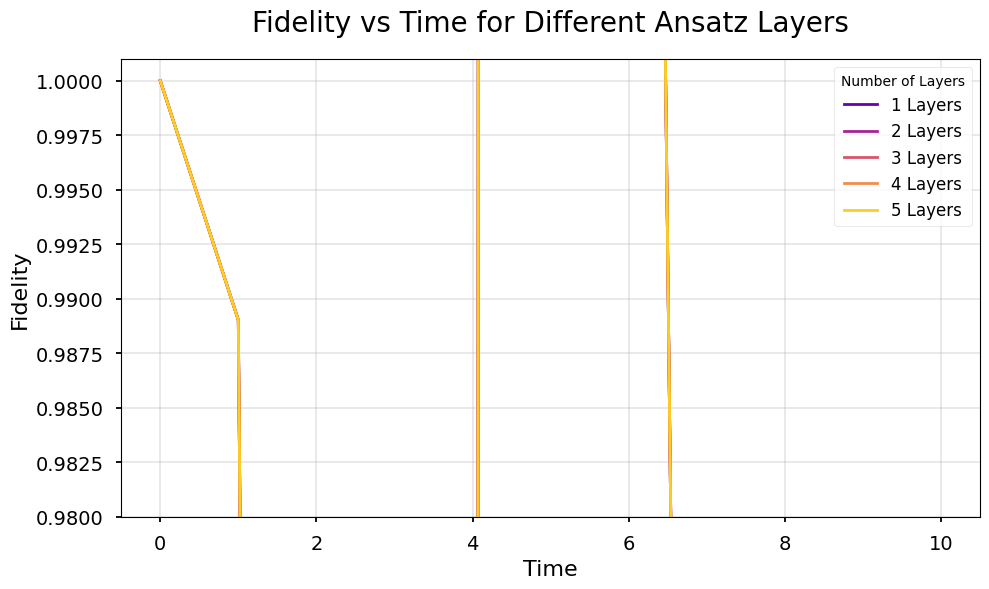

In [1]:
# Initialize the simulation parameters
from imports import *
from globalMethods import *
from vqteMethods import *
from exactDiagMethods import *
from fidelity_main import *

layers = 5
time = 10
dt = 1
run_multiple_layers(layers, time, dt)
        
#         gamma_L = 1
#         gamma_R = 0

#         eps = 1.0

#         mu_L= 1.0
#         mu_R= 1.0

#         # Temperature of Reserviors
#         T_L = 10
#         T_R= 100

#         time = 5
#         dt = 0.05

#         layers = 3

#         for layer in range(1, layers+1):
#                 run_multiple_layers(layer, gamma_L, gamma_R, eps, mu_L, mu_R, T_L, T_R, time, dt)




# def run_multiple_layers(layer, gamma_L, gamma_R, eps, mu_L, mu_R, T_L, T_R, time, dt):

#         nt = int(time/dt)
#         beta_L=1/T_L
#         beta_R=1/T_R
#         F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
#         F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)


#         # Generate Hamiltonians
#         exact_diag_ham = build_exact_diag_hamiltonian(eps)
#         ham_real, ham_imag = hamiltonian_generation(eps, gamma_L, gamma_R, F_R,F_L)
#         print("Exact Diag Ham: ", exact_diag_ham)
#         print("Ham real: ", ham_real)
#         print("Ham imag: ", ham_imag)


#         # Generate initial states
#         vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real, layer)
#         print("Initil State : " , vqte_init_state)
#         print("Exact Initial : ", exact_diag_init_state)

#         # Perform exact diagonalization
#         exact_diag_results, time_points, exact_fidelity = perform_exact_diag(gamma_L, F_L, gamma_R, F_R, dt, nt, exact_diag_init_state, exact_diag_ham)
    
#         # Perform vqte simulation
#         vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)

#         #Output results
#         output_results(vqte_results, exact_diag_results, time, nt, time_points)
#         print(vqte_results[-1])
